In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import glob
import json

In [2]:
def extract_ground_truth_variables(heading_ts, fly_pos, window_len = 1200):

    """
    This function calculates the change in the fly's orientation and forward displacement.
    The forward displacement is calculated by projecting the change in position of the fly
    onto the fly's heading vector.
    Adapted from the exercises.
    """
    # Change in locomotion state (heading & displacement) ==========
    # Calculate change in fly orientation over proprioceptive time window (Δheading)
    fly_orientation_xy = np.stack([np.cos(heading_ts), np.sin(heading_ts)], axis=1)

    heading_diff = heading_ts[window_len:] - heading_ts[:-window_len]
    heading_diff = (heading_diff + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, π]

    # Same for displacement projected in the direction of fly's heading
    # Use projection formula: proj_v(u) = (u · v) / (v · v) * v where v is the fly's
    # heading vector and u is the change in position
    fly_disp_xy = np.diff(fly_pos, axis=0, prepend=0)
    fly_orientation_xy_norm = np.linalg.norm(fly_orientation_xy, axis=1)
    fly_orientation_xy_unit = fly_orientation_xy / fly_orientation_xy_norm[:, None]
    udotv = np.sum(fly_disp_xy * fly_orientation_xy_unit, axis=1)
    vdotv = np.sum(fly_orientation_xy_unit * fly_orientation_xy_unit, axis=1)
    forward_disp_mag = udotv / vdotv
    forward_disp_total = np.cumsum(forward_disp_mag)
    forward_disp_total_diff = forward_disp_total[window_len:] - forward_disp_total[:-window_len]
    
    return heading_diff, forward_disp_total_diff

def fit_1d_linear_model(x, y):
    k, b = np.polyfit(x, y, deg=1)
    model = np.poly1d([k, b])
    y_pred = model(x)
    r2 = 1 - np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2)
    return k, b, r2

def absolute_to_relative_velocity(
        v: np.ndarray, heading: np.ndarray
    ) -> np.ndarray:
    """
    This function converts an absolute velocity to a relative velocity
    with respect to the heading of the fly.
    """
    cos_a = np.cos(-heading)
    sin_a = np.sin(-heading)

    # Element-wise rotation
    v_x_rel = v[:, 0] * cos_a - v[:, 1] * sin_a
    v_y_rel = v[:, 0] * sin_a + v[:, 1] * cos_a

    return np.stack([v_x_rel, v_y_rel], axis=1)

In [3]:
# Extract all files 
window_len = 1200

path_true_x = glob.glob("true_x*.npy")
path_true_y = glob.glob("true_y*.npy")
path_true_heading  = glob.glob("true_heading*.npy")
path_true_roll = glob.glob("true_roll*.npy")
path_velocity = glob.glob("true_velocity*.npy")

path_pred_dist = glob.glob("pred_distance*.npy")
path_pred_heading = glob.glob("pred_heading_*.npy")
path_pred_head_opt = glob.glob("pred_headingoptic*.npy")

len_trials = len(path_true_x)
true_headings = []; true_disps = []; true_optic_headings = []

pred_headings = []; pred_optic_headings = [];pred_disps = []
velocities_x = []; velocities_y = []

for i in range(len_trials):
    print(f'trajectory {i+1}/{len(path_true_x)} , {path_true_x[i]}')

    # True position
    true_p = np.stack([np.load(path_true_x[i]), np.load(path_true_y[i])], axis=1)

    true_heading = np.load(path_true_heading[i])

    # For odometry
    true_heading_fly, true_disp = extract_ground_truth_variables(true_heading, true_p)
    true_headings.extend(true_heading_fly)
    true_disps.extend(true_disp)
    
    #For optic flow - roll or obs'heading' but at the same time resolution than optic flow
    true_roll = np.load(path_true_roll[i])
    true_optic_headings.extend(true_roll)

    # velocity to inform the model
    velocity_abs = np.load(path_velocity[i])
    # velocity = absolute_to_relative_velocity(velocity_abs, true_heading) # NOPE
    velocity_x = velocity_abs[:,0] # only x velocity
    velocity_y = velocity_abs[:,1] 
    velocities_x.extend(velocity_x[window_len:]) # before that we dont have proprio infered data
    velocities_y.extend(velocity_y[window_len:]) 

    # PREDICTIONS
    pred_disp = np.load(path_pred_dist[i])
    # pad with nan since we don't have predictions for the first proprioceptive time window
    # pred_disp = np.concatenate([np.full((window_len), np.nan), pred_disp], axis=0)
    pred_disps.extend(pred_disp)
    
    pred_heading = np.load(path_pred_heading[i])
    pred_headings.extend(pred_heading)

    pred_optic_heading = np.load(path_pred_head_opt[i])
    pred_optic_headings.extend(pred_optic_heading)
    
    

    print('absolute velocity', velocity_abs.shape)
    print('true_disp', true_disp.shape)
    print('pred_disp', pred_disp.shape)

    print('true_heading', true_heading_fly.shape)
    print('pred_heading', pred_heading.shape)

    print('true_roll', true_roll.shape)
    print('pred_roll (opt h)', pred_optic_heading.shape)
    
    print('\n')
assert len(pred_disps) == len(true_disps)
assert len(pred_headings) == len(true_headings)
assert len(pred_optic_headings) == len(true_optic_headings)

trajectory 1/10 , true_x_10.npy
absolute velocity (19084, 2)
true_disp (17884,)
pred_disp (17884,)
true_heading (17884,)
pred_heading (17884,)
true_roll (191,)
pred_roll (opt h) (191,)


trajectory 2/10 , true_x_12.npy
absolute velocity (25445, 2)
true_disp (24245,)
pred_disp (24245,)
true_heading (24245,)
pred_heading (24245,)
true_roll (255,)
pred_roll (opt h) (255,)


trajectory 3/10 , true_x_21.npy
absolute velocity (12483, 2)
true_disp (11283,)
pred_disp (11283,)
true_heading (11283,)
pred_heading (11283,)
true_roll (125,)
pred_roll (opt h) (125,)


trajectory 4/10 , true_x_26.npy
absolute velocity (19512, 2)
true_disp (18312,)
pred_disp (18312,)
true_heading (18312,)
pred_heading (18312,)
true_roll (196,)
pred_roll (opt h) (196,)


trajectory 5/10 , true_x_36.npy
absolute velocity (18178, 2)
true_disp (16978,)
pred_disp (16978,)
true_heading (16978,)
pred_heading (16978,)
true_roll (182,)
pred_roll (opt h) (182,)


trajectory 6/10 , true_x_38.npy
absolute velocity (23156, 2)
true

### Explore velocities 

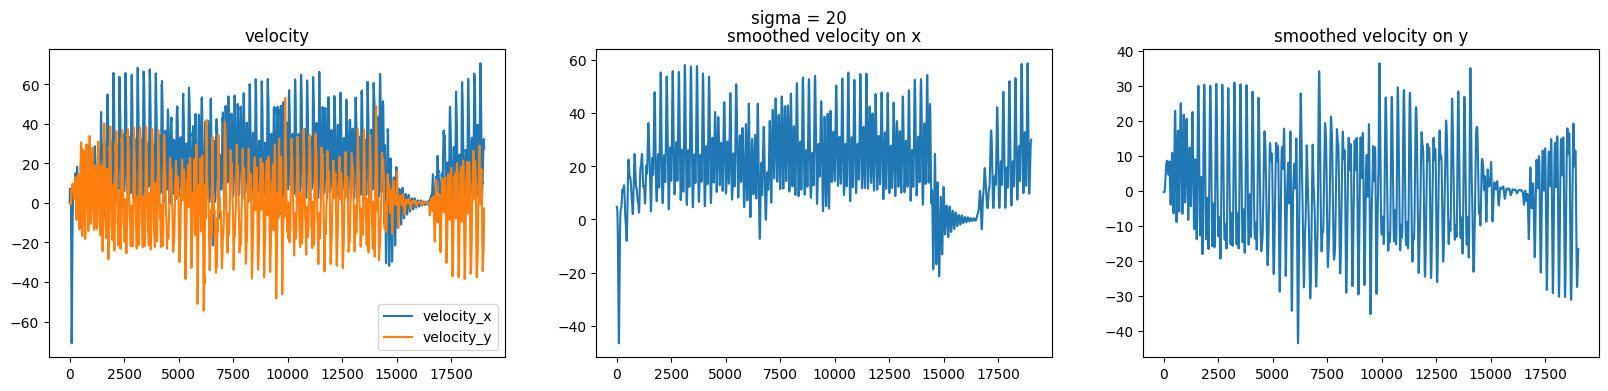

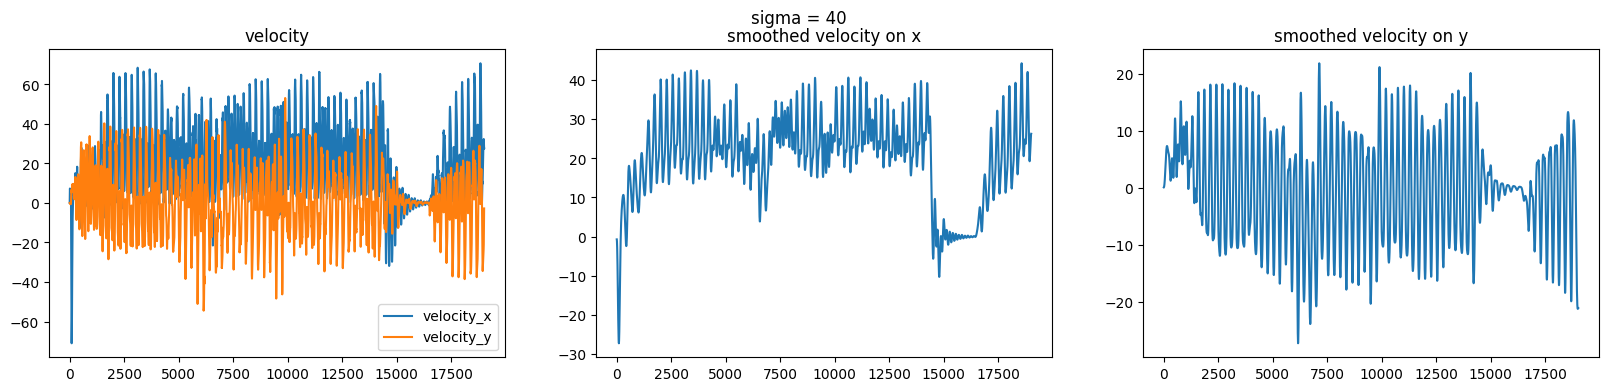

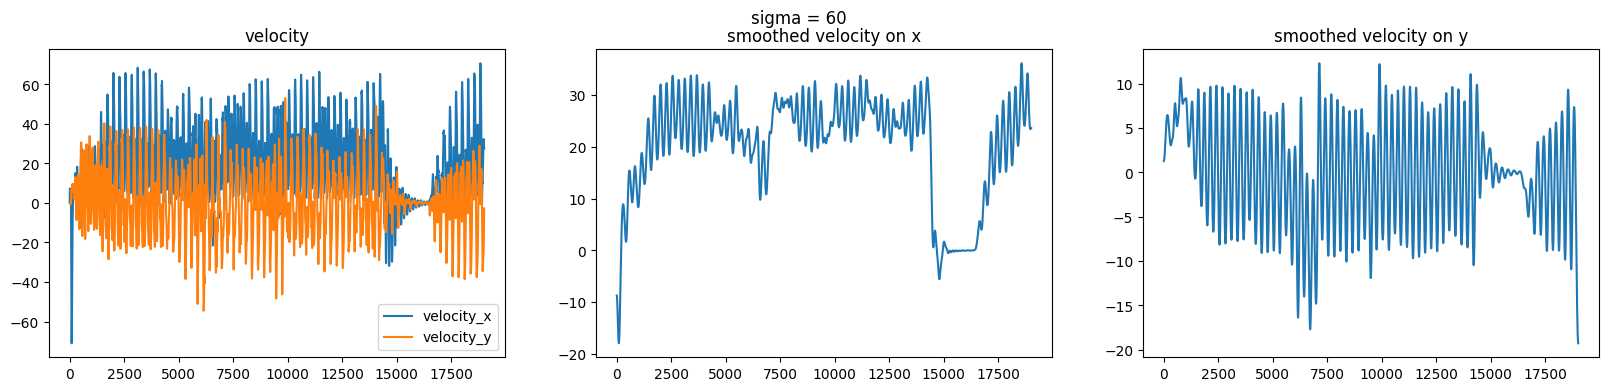

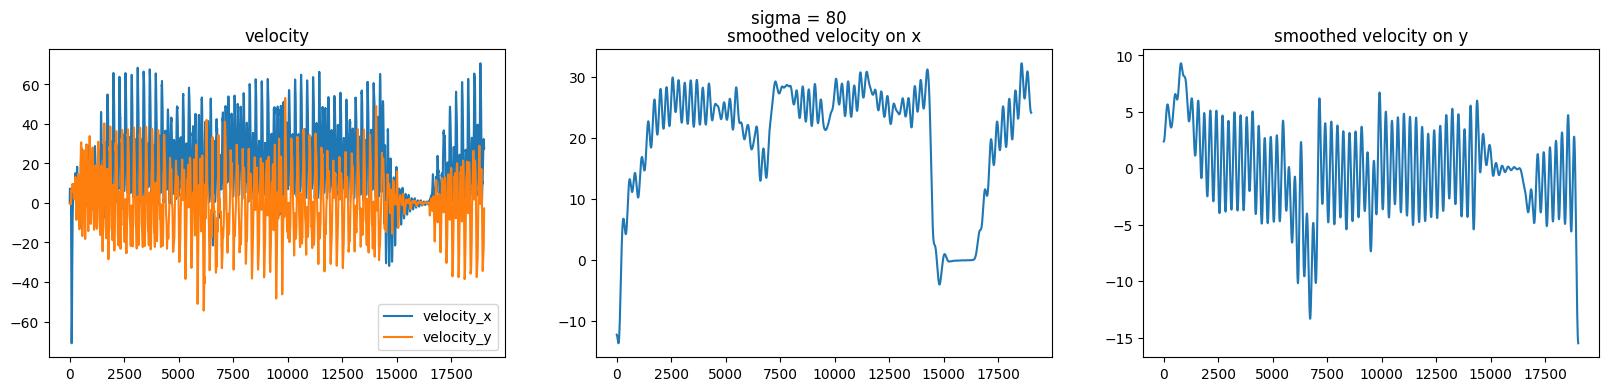

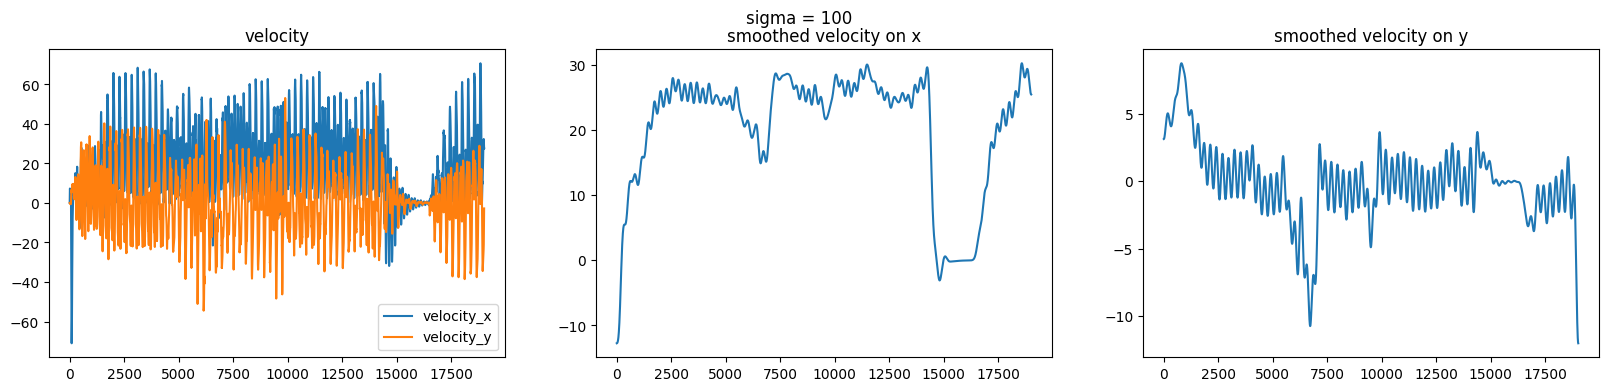

In [5]:
# Velocity is in fly centric coordinates

from scipy.ndimage import gaussian_filter1d
for sigma in [20, 40, 60, 80, 100]:
    
    smoothed_velocity_x = gaussian_filter1d(velocity_x, sigma=sigma)
    smoothed_velocity_y = gaussian_filter1d(velocity_y, sigma=sigma)

    fig, ax = plt.subplots(1, 3, figsize=(20, 4))
    plt.suptitle(f'sigma = {sigma}')
    ax[0].plot(velocity_x, label='velocity_x')
    ax[0].plot(velocity_y, label='velocity_y')
    ax[0].set_title('velocity')
    ax[0].legend()

    ax[1].plot(smoothed_velocity_x)
    ax[1].set_title('smoothed velocity on x')

    ax[2].plot(smoothed_velocity_y)
    ax[2].set_title('smoothed velocity on y')
    plt.show()

# MODELS

# Proprioception only models - heading and distance

In [6]:
k_prop_head, b_prop_head, r2_prop_head = fit_1d_linear_model(pred_headings, true_headings)
k_prop_disp, b_prop_disp, r2_prop_disp = fit_1d_linear_model(pred_disps, true_disps)

prop_heading_model = np.poly1d([k_prop_head, b_prop_head])
prop_disp_model = np.poly1d([k_prop_disp, b_prop_disp])

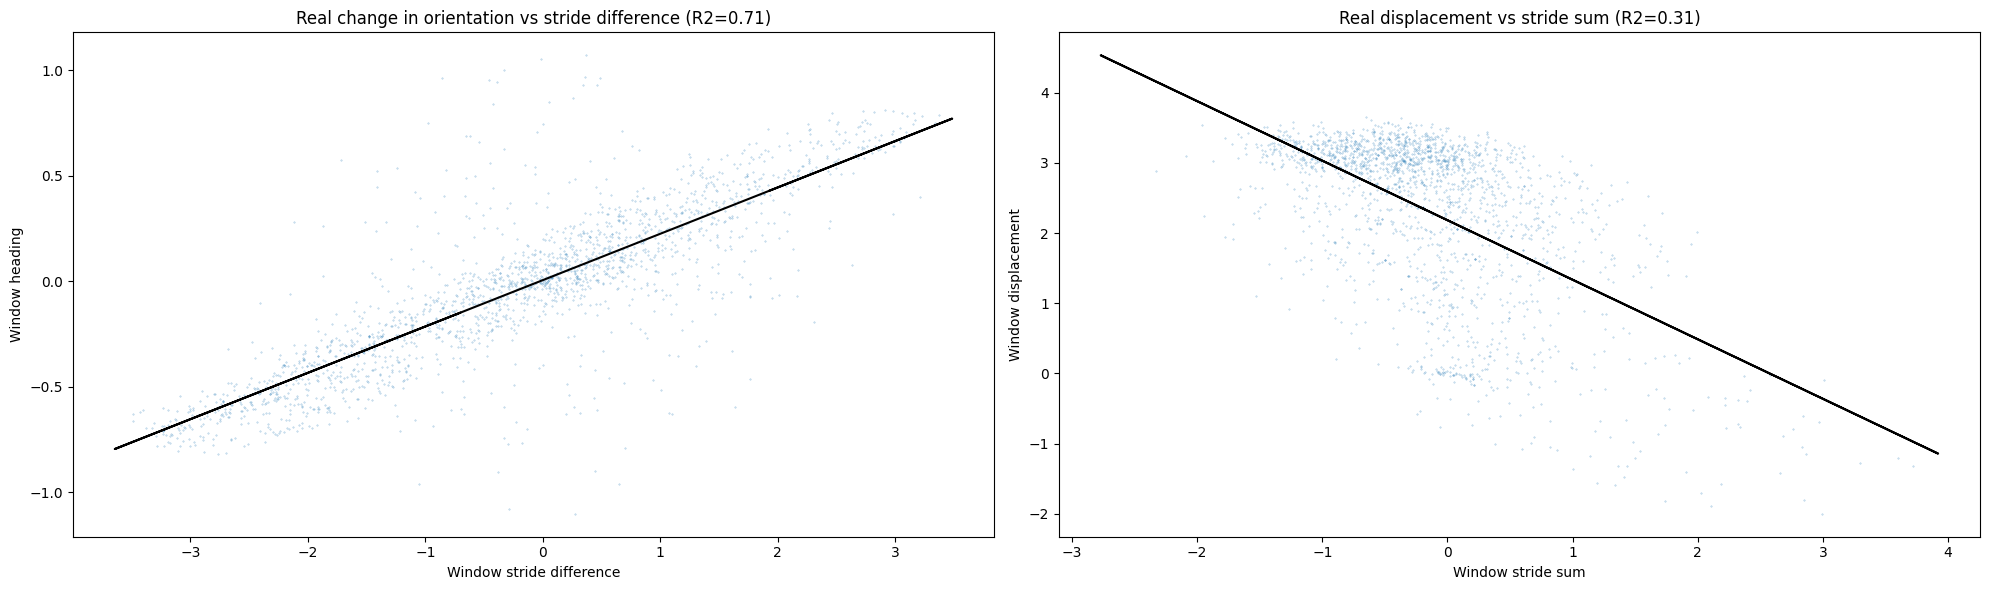

In [9]:
# dataset_belonging = np.repeat(np.arange(len_trials), len(pred_dists))

fig, axs = plt.subplots(1, 2, figsize=(20, 6), tight_layout=True)
axs[0].scatter(pred_headings[::100], true_headings[::100], alpha=0.5, s=0.1)
axs[0].plot(pred_headings, prop_heading_model(pred_headings), color="black")
axs[0].set_xlabel("Window stride difference")
axs[0].set_ylabel("Window heading")
axs[0].set_title(f"Real change in orientation vs stride difference (R2={r2_prop_head:.2f})")

axs[1].scatter(pred_disps[::100], true_disps[::100], alpha=0.5, s=0.1)
axs[1].plot(pred_disps, prop_disp_model(pred_disps), color="black")
axs[1].set_xlabel("Window stride sum")
axs[1].set_ylabel("Window displacement")
axs[1].set_title(f"Real displacement vs stride sum (R2={r2_prop_disp:.2f})")

plt.show()

#### Save the slope and intercept of each model, to rebuild the model later

In [10]:
models_data = {
    'prop_heading_model': {'slope': float(k_prop_head),'intercept': float(b_prop_head)},
    'prop_disp_model': {'slope': float(k_prop_disp),'intercept': float(b_prop_disp)}
}

save_path = os.path.join(os.getcwd(), '..' ,'..', 'submission', 'proprioceptive_models.json')
with open(save_path, 'w') as f:
    json.dump(models_data, f, indent=4)

# Displacement - Multivariate model with steps and velocity 

In [17]:
from sklearn.linear_model import LinearRegression

# Fit a linear regression model	
# smoothe the velocity
velocities_x_sm = gaussian_filter1d(velocities_x, sigma=50)
# velocities_y_sm = gaussian_filter1d(velocities_y, sigma=100)


pos_x = (np.array(velocities_x_sm) * 1e-4).reshape(-1, 1)
# pos_y = (np.array(velocities_y_sm) * 1e-4   ).reshape(-1, 1)
X1 = np.array(pred_disps).reshape(-1, 1)

X = np.hstack([X1, pos_x]) #, pos_y
y = np.array(true_disps).reshape(-1, 1)

model = LinearRegression()
model.fit(X, y)

posx10_sm = np.array(gaussian_filter1d(velocity_x[window_len:], sigma=50)).reshape(-1, 1)*1e-4
# posy10_sm = np.array(gaussian_filter1d(velocity_y[window_len:], sigma=100)).reshape(-1, 1)*1e-4
x10 = np.hstack([np.array(pred_disp).reshape(-1, 1), posx10_sm]) #, posy10_sm
y10 = np.array(pred_disp).reshape(-1, 1)

r2_prop_disp = model.score(X, y)
print('r2_prop_disp', r2_prop_disp)
print('coef', model.coef_)

disp_multivar_model = {
    "coefs": model.coef_.tolist(),       
    "intercept": model.intercept_.tolist() 
}

# Save to JSON
save_path = os.path.join(os.getcwd(), '..' ,'..', 'submission', 'proprioceptive_mulitvar_model.json')
with open(save_path, "w") as f:
    json.dump(disp_multivar_model, f)

# with open("model.json", "r") as f:
#     model_data = json.load(f)

# # Create a new LinearRegression model
# new_model = LinearRegression()
# new_model.coef_ = np.array(model_data["coef"])
# new_model.intercept_ = np.array(model_data["intercept"])

r2_prop_disp 0.31436812679262505
coef [[-8.476712e-01  5.347779e-04]]


hardly any better for now but needs improvemetns

In [51]:
# A tester 
#  from sklearn.svm import SVR
# model = SVR(kernel='rbf', C=10, epsilon=0.1)
# model.fit(X, y.ravel())
# r2 = model.score(X, y)

# Displacement - model with velocity only 

In [43]:
smoothed_velocities = gaussian_filter1d(velocities_x, sigma=100)

disp_pred_velocity = np.array(smoothed_velocities).reshape(-1, 1) *1e-4

X_velocity = np.array(disp_pred_velocity).reshape(-1, 1)
y_velocity = np.array(true_disps).reshape(-1, 1)
model_velocity = LinearRegression()
model_velocity.fit(X_velocity, y_velocity)


k_velocity = model_velocity.coef_[0][0]
b_velocity = model_velocity.intercept_[0]
print('r2_velocity', model_velocity.score(X_velocity, y_velocity))
print('coef', model_velocity.coef_, 'intercept', model_velocity.intercept_)



# smoothed_velocity_x = gaussian_filter1d(velocity_x[window_len:], sigma=100)
# x10 = np.array(smoothed_velocity_x).reshape(-1, 1)
# y10 = np.array(true_disp).reshape(-1, 1)
# predictions = model.predict(x10) 
# prediciton of 0.249
# print('r2_velocity', model.score(x10, y10))

r2_velocity 0.5608648070134711
coef [[798.95905]] intercept [0.7321856]


In [ ]:
# save the model to JSON
model_velocity_dict = {
    "coefs": model_velocity.coef_.tolist(),       
    "intercept": model_velocity.intercept_.tolist() 
}
save_path = os.path.join(os.getcwd(), '..' ,'..', 'submission', 'velocity_model.json')
with open(save_path, "w") as f:
    json.dump(model_velocity_dict, f)

# Heading and Optic flow - Multi and univariate models

In [53]:
len(true_optic_headings), len(pred_optic_headings)

(2095, 2095)

In [54]:
X1 = np.array(pred_optic_headings).reshape(-1, 1)
X2 = prop_heading_model(pred_headings).reshape(-1, 1)
X2 = X2[::100]
X1 = X1[:X2.shape[0]]
X1.shape, X2.shape

((1972, 1), (1972, 1))

In [27]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

model_1d = LinearRegression()
model_multivar = LinearRegression()

X1 = np.array(pred_optic_headings).reshape(-1, 1)
X2 = prop_heading_model(pred_headings).reshape(-1, 1) 
X2 = X2[::100]
y = np.array(true_optic_headings).reshape(-1, 1)


heading_flow_model  = model_1d.fit(X1, y)


# whichever has less samples sets the number of samples
min_ids = np.minimum(X1.shape[0], X2.shape[0])

X1 = X1[:min_ids]
X2 = X2[:min_ids]
y = y[:min_ids]

X = np.hstack([X1, X2])
heading_flow_model_multivar = model_multivar.fit(X, y)


y_pred_m = heading_flow_model_multivar.predict(X)
y_pred = heading_flow_model.predict(X1)
print('Univar', heading_flow_model.score(X1, y))
print('Multivar', heading_flow_model_multivar.score(X, y))

Univar 0.27646064999888365
Multivar 0.2814638746011521


In [28]:
X.shape, y.shape

((1972, 2), (1972, 1))

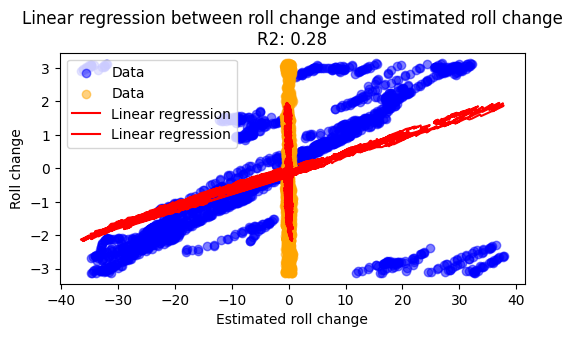

In [29]:
plt.figure(figsize=(6, 3))
plt.scatter(X[:,0], y, label="Data", c="blue", alpha=0.5)
plt.scatter(X[:,1], y, label="Data", c="orange", alpha=0.5)
plt.plot(X, y_pred_m, color="red", label="Linear regression")
plt.xlabel("Estimated roll change")
plt.ylabel("Roll change")
plt.legend()
plt.title(f"Linear regression between roll change and estimated roll change\nR2: {heading_flow_model_multivar.score(X, y):.2f}")

plt.show()

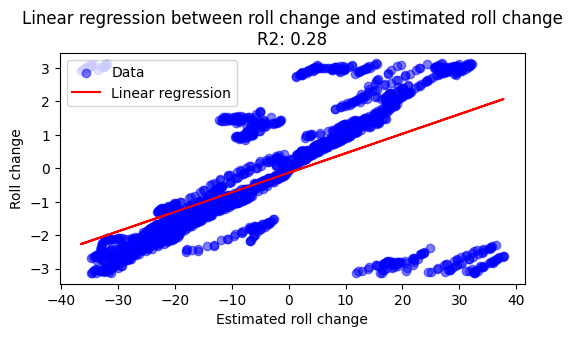

In [30]:
plt.figure(figsize=(6, 3))
plt.scatter(X1, y, label="Data", c="blue", alpha=0.5)
plt.plot(X1, y_pred, color="red", label="Linear regression")
plt.xlabel("Estimated roll change")
plt.ylabel("Roll change")
plt.legend()
plt.title(f"Linear regression between roll change and estimated roll change\nR2: {heading_flow_model.score(X1, y):.2f}")

plt.show()

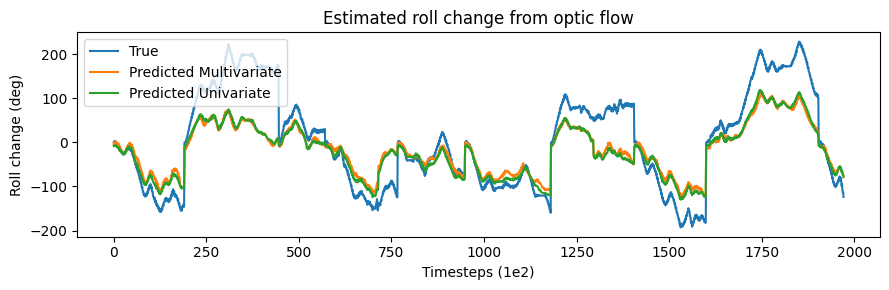

In [31]:
# unwrapping the roll

fly_roll_hist = np.unwrap(true_optic_headings, discont=np.pi)
vision_window_length = 200

time = np.arange(len(fly_roll_hist)) * 1e-4


X1 = np.array(pred_optic_headings).reshape(-1, 1)
X2 = prop_heading_model(pred_headings).reshape(-1, 1) 
X2 = X2[::100]

# whichever has less samples sets the number of samples
min_ids = np.minimum(X1.shape[0], X2.shape[0])

X1 = X1[:min_ids]
X2 = X2[:min_ids]
X = np.hstack([X1, X2])

y_pred_m = heading_flow_model_multivar.predict(X)
y_pred = heading_flow_model.predict(X1)
# version with only 


fly_roll_hist = fly_roll_hist[:min_ids]

fig, ax = plt.subplots(1, 1, figsize=(9, 3), tight_layout=True)
ax.plot( np.rad2deg(fly_roll_hist), label='True')
ax.plot(np.rad2deg(y_pred_m), label='Predicted Multivariate')
ax.plot(np.rad2deg(y_pred), label='Predicted Univariate')
# twin_ax = ax.twinx()
# twin_ax.plot(time, np.rad2deg(pred_optic_headings), color="red", label="Predicted roll change")
# twin_ax.set_ylabel("Roll (deg)")

ax.set_title("Estimated roll change from optic flow")
ax.set_xlabel("Timesteps (1e2)")
ax.set_ylabel("Roll change (deg)")
ax.legend(loc="upper left")
plt.show()


In [32]:
# Save the slope and intercept of each model, to rebuild the model later
heading_models_data = {
    'heading_flow_model': { 'slope': float(heading_flow_model.coef_[0][0]), 'intercept': float(heading_flow_model.intercept_[0])},
    'heading_flow_model_multivar': { 
        'slopes': heading_flow_model_multivar.coef_[0].tolist(), 'intercept': float(heading_flow_model_multivar.intercept_[0])
    }
}

save_path = os.path.join(os.getcwd(), '..' ,'..', 'submission', 'heading_optic_models.json')
with open(save_path, 'w') as f:
    json.dump(heading_models_data, f, indent=4)

### Testing algorithm for x,y prediction with one trajectory

In [40]:
def create_heading_final(proprioceptive_heading_pred, proprioceptive_heading_model, optic_heading_pred, optic_heading_model, optic_window = 100, proprioceptive_window = 1200):
    N = len(proprioceptive_heading_pred) + proprioceptive_window
    heading_final = np.zeros(N)
    optic_indices = np.arange(0, N, optic_window)
    
    proprio_heading = proprioceptive_heading_model(np.array(proprioceptive_heading_pred).reshape(-1, 1)).flatten()
    # fill with zeros the first proprioceptive window so that later the delta is correct
    proprio_heading = np.concatenate([np.full((proprioceptive_window), 0), proprio_heading], axis=0)/ proprioceptive_window

    optic_headings_corrected = optic_heading_model.predict(np.array(optic_heading_pred).reshape(-1, 1)).flatten()
    
    for i, idx in enumerate(optic_indices): # every optic window set value to optic heading
        heading_final[idx] = optic_headings_corrected[i]

    # Fill in the initial proprioceptive window using optic flow only 
    for i in range(0, proprioceptive_window - optic_window, optic_window):
        # carry forward last optic value (step-wise fill)
        for j in range(i + 1, i + optic_window):
            heading_final[j] = heading_final[j - 1]

    # Between optic updates use the proprioceptive heading
    for i in range(len(optic_indices) - 1):
        for j in range(optic_indices[i] + 1, optic_indices[i + 1]):
            heading_final[j] = heading_final[j - 1] + proprio_heading[j]

    # Handle the final segment after the last optic update
    for j in range(optic_indices[-1] + 1, N):
        heading_final[j] = heading_final[j - 1] + proprio_heading[j]
        
    return heading_final


def create_displacement_final(proprioceptive_dist_pred, prop_disp_model, velocities, velocity_model, proprioceptive_window = 1200):
    from scipy.ndimage import gaussian_filter1d
    N = len(proprioceptive_dist_pred) + proprioceptive_window
    disp_final = np.zeros(N)

    # Velocity for the first proprioceptive window
    smoothed_velocity = gaussian_filter1d(velocities, sigma=20)
    disp_pred_velocity = velocity_model.predict(np.array(smoothed_velocity).reshape(-1, 1)).flatten()
    disp_final[:proprioceptive_window] = disp_pred_velocity[:proprioceptive_window]

    proprio_disp_pred = prop_disp_model(proprioceptive_dist_pred)
    disp_final[proprioceptive_window:] = proprio_disp_pred

    return disp_final




In [41]:
chosen_seed = 9 # seed 75

proprioceptive_heading_pred = np.load(path_pred_heading[chosen_seed])
proprioceptive_dist_pred = np.load(path_pred_dist[chosen_seed])
optic_heading_pred = np.load(path_pred_head_opt[chosen_seed])

true_heading = np.load(path_true_heading[chosen_seed])
true_p = np.stack([np.load(path_true_x[chosen_seed]), np.load(path_true_y[chosen_seed])], axis=1)
obs_heading_diff, true_disp = extract_ground_truth_variables(true_heading, true_p)
obs_heading = obs_heading_diff

true_roll = np.load(path_true_roll[chosen_seed])
velocity_x = np.load(path_velocity[chosen_seed])[:,0]
velocity_y = np.load(path_velocity[chosen_seed])[:,1]
optic_heading_model = heading_flow_model

In [44]:
# Earlier version

# displacement_diff_pred = prop_disp_model(proprioceptive_dist_pred)
# displacement_diff_pred = np.concatenate([np.full((window_len), 0), displacement_diff_pred], axis=0) # pad with 0 before the first window

# no need for cumsum here since it has already been done before the proprioceptive model 
# and that we train on the fly roll and not on the heading differences 
# heading_pred = optic_heading_model.predict(np.array(optic_heading_pred).reshape(-1, 1))

# TODO DONE improve this simplification 
# Here we do as if the heading does not change in between optic flow updates 
# As if going in a straight line in between 
# in the lab they interpolate but we would actually like to have the optic flow measure incremented by the delta headings of the proprioceptive model 
# n_chunks = int(np.ceil(len(displacement_diff_pred) / 100))
# print('n_chunks', n_chunks)
# displacement_diff_pred_subsampled = np.cumsum(np.array([displacement_diff_pred[i*100 : (i+1)*100].sum()/window_len for i in range(n_chunks)]))
# flow_pred_heading_interp = np.interp(displacement_diff_tim, flow_heading_time, flow_pred_heading) # DANS LA SERIE
# print('displacement_diff_pred', displacement_diff_pred, 'subsampled', displacement_diff_pred_subsampled.shape)


# Newer version

heading_final = create_heading_final(proprioceptive_heading_pred, prop_heading_model, optic_heading_pred, optic_heading_model)
disp_final = create_displacement_final(proprioceptive_dist_pred, prop_disp_model, velocity_x, model_velocity)

displacement_diff_x_pred = disp_final[1200:].flatten() * np.cos(heading_final[1200:]).flatten()
displacement_diff_y_pred = disp_final[1200:].flatten() * np.sin(heading_final[1200:]).flatten()

displacement_x = displacement_diff_x_pred
displacement_y = displacement_diff_y_pred

print('displacement_diff_x_pred', displacement_diff_x_pred[-1])
print('displacement_diff_y_pred', displacement_diff_y_pred[-1])
print('heading_final', heading_final[-1])

pos_x_pred = np.cumsum(displacement_x/ window_len)
pos_y_pred = np.cumsum(displacement_y/ window_len)
print('pos_x_pred', pos_x_pred[-1], 'pos_y_pred', pos_y_pred[-1])
pos_pred = np.stack([pos_x_pred, pos_y_pred], axis=1)
# pos_pred = np.concatenate([np.full((window_len, 2), np.nan), pos_pred], axis=0) # pad with nan before the first window

displacement_diff_x_pred 1.0279016734821802
displacement_diff_y_pred -2.1176797050574954
heading_final -1.1189044537725394
pos_x_pred 4.808919988305413 pos_y_pred -31.01807000426061


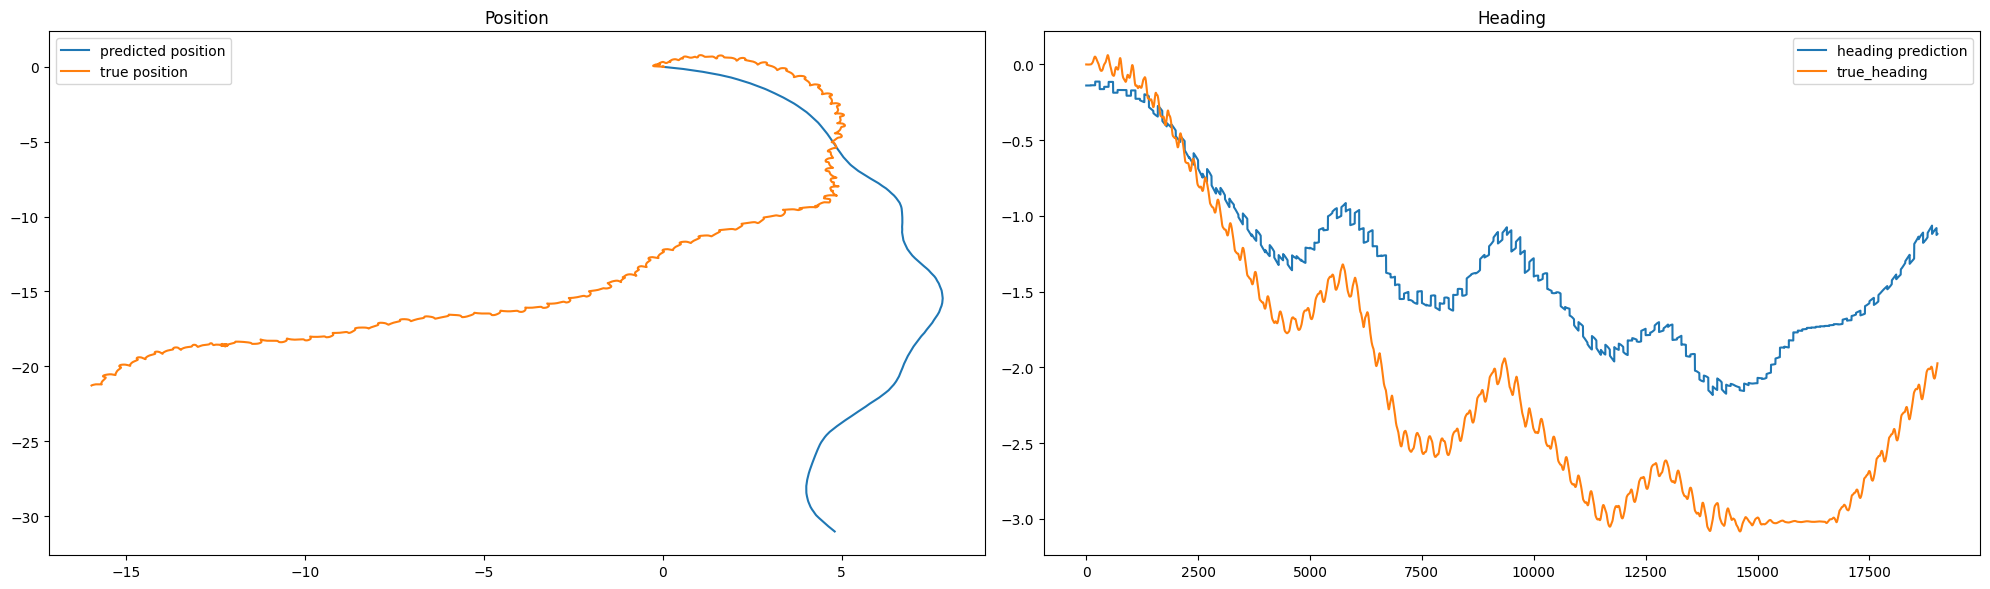

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6), tight_layout=True)
ax[0].plot(pos_pred[:, 0], pos_pred[:, 1], label='predicted position')
ax[0].plot(true_p[:, 0], true_p[:, 1], label='true position')
ax[0].set_title('Position')
ax[0].legend()

ax[1].plot(heading_final, label='heading prediction')
ax[1].plot(true_heading, label='true_heading')
ax[1].set_title('Heading')
ax[1].legend();

In [114]:
# plt.plot(displacement_diff_pred)
# plt.plot(proprioceptive_dist_pred)
# plt.plot(displacement_diff_pred_subsampled)

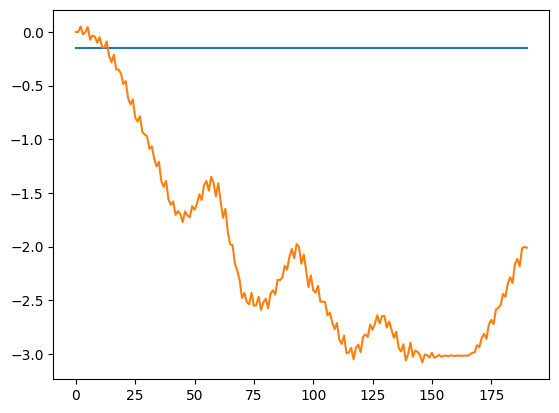

In [107]:
plt.plot(optic_heading_pred)
plt.plot(true_roll)

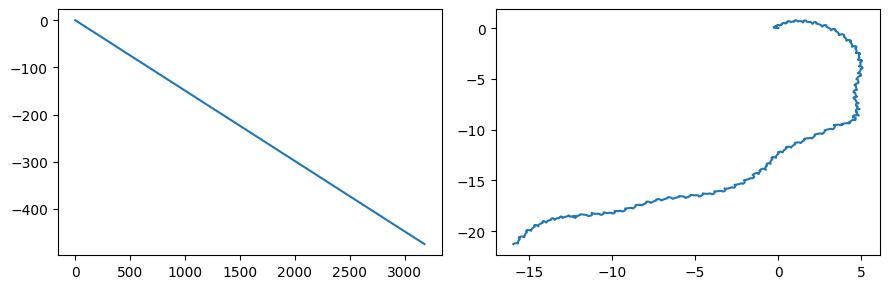

In [101]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3), tight_layout=True)
ax[0].plot(pos_pred[:,0], pos_pred[:,1], label='predicted')
ax[1].plot(position[:,0], position[:,1], label='true')